In [188]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

### Parameters

In [241]:
iteration = 5
PhenoGraph_k = 100
node_label = 'TMECellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 50,
    'knn_k': 10
}
patient_filtering_dict = {
    'Clinical Subtype': 'HR+/HER2-'
}

# Discovery

### Load Gram matrix and clinical data

In [242]:
if iteration == 0:
    SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
else:
    SoftWL_dict= pickle.load(
        open(
            os.path.join(
                PROJECT_ROOT,
                "Output",
                "b_Soft_WL_Kernel_random_split",
                "Danenberg",
                "Subset_1",
                "SoftWL_dict_iter_"
                + str(iteration)
                + "_PhenoGraph_k_"
                + str(PhenoGraph_k)
                + "_"
                + node_label
                + ".pkl",
            ),
            "rb",
        ),
    )
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

243 patients are included


### Community detection

In [243]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

### Survival analysis for subgroups

In [244]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i,  'Clinical Subtype'].values[0] for i in Patient_IDs])
print(np.unique(Clinical_subtype))
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

['HR+/HER2-']
243 patients are included
S1 (N = 47):
Survival: hr = 1.754042799324772, p = 0.033792121548563134
S2 (N = 63):
Survival: hr = 1.1594110754725868, p = 0.5762375489944407
S3 (N = 20):
Survival: hr = 1.116508947039579, p = 0.7823389172001216
S4 (N = 47):
Survival: hr = 0.871213205547885, p = 0.6748998451431547
S5 (N = 43):
Survival: hr = 0.5917490209303362, p = 0.14208964096387078
S6 (N = 23):
Survival: hr = 0.44419918980875855, p = 0.16921253072635814


In [245]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, len(HR)+1):
    Gram_matrix_ = Gram_matrix[Subgroup_ids_ == i, :][:, Subgroup_ids_ == i]
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

47 subgroup 1 patients, averaged Intra-group similarity is 0.56 
63 subgroup 2 patients, averaged Intra-group similarity is 0.53 
20 subgroup 3 patients, averaged Intra-group similarity is 0.68 
47 subgroup 4 patients, averaged Intra-group similarity is 0.57 
43 subgroup 5 patients, averaged Intra-group similarity is 0.59 
23 subgroup 6 patients, averaged Intra-group similarity is 0.64 
Overall 243 patients, averaged Intra-group similarity is 0.37 


### Plot population graph

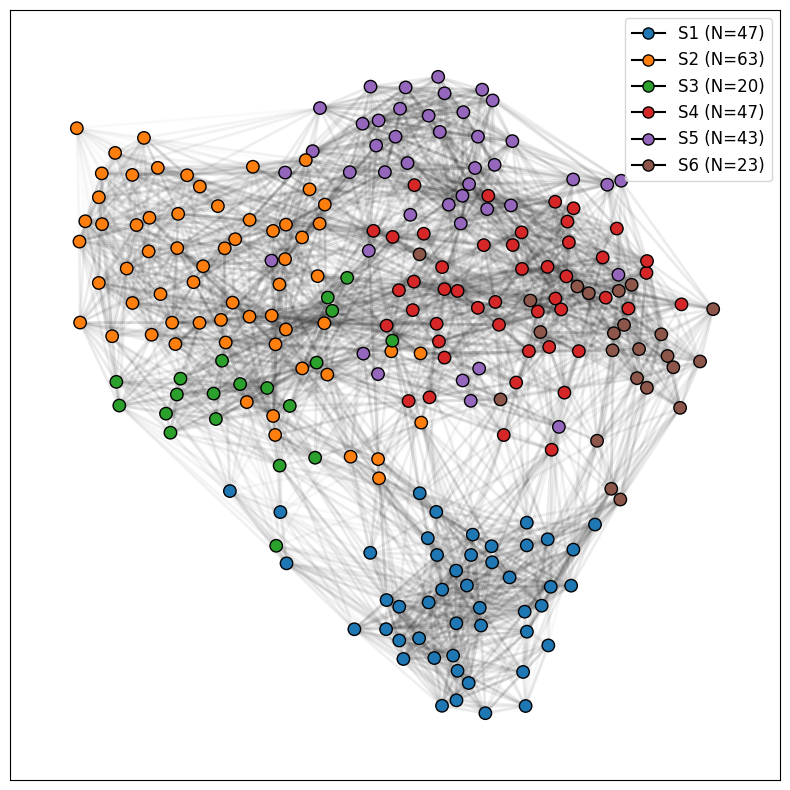

In [246]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    'knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids_], 
            edgecolors="black"
        )
if np.sum(Subgroup_ids_ == 0)>0:
    handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color = 'k',
            label=f"Unclassified (N={np.sum(Subgroup_ids_ == 0)})",
            markerfacecolor=color_palette[0],
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    ]
else:
    handles = []
for i in range(1, len(np.unique(Subgroup_ids_[Subgroup_ids_!=0]))+1):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color = 'k',
        label=f"S{i} (N={np.sum(Subgroup_ids_ == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles, fontsize = 12)
plt.show()

### Plot hazard ratio

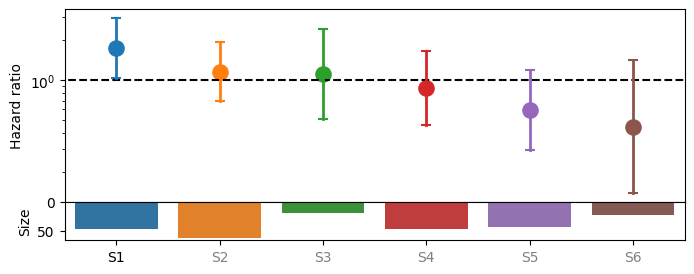

In [247]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Plot K-M Plot

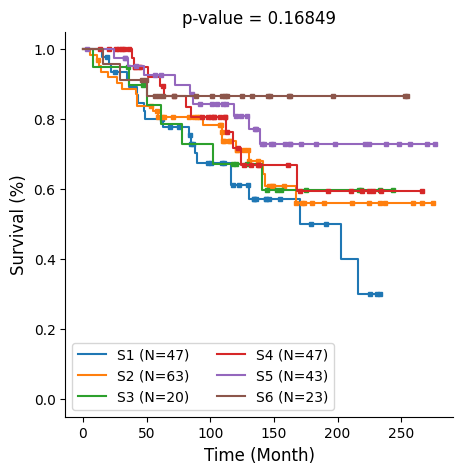

In [248]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Find overpresented patterns

In [249]:
from overpresented_patterns import find_overpresented_patterns
Overpresented_patterns = find_overpresented_patterns(
    Histograms_, Subgroup_ids_, HR, adjust=False
)
print(Overpresented_patterns)


{1: [0, 1], 2: [33, 37, 21, 53, 54, 25, 59, 29], 3: [4, 5], 4: [16, 34, 31], 5: [8, 17, 2, 3], 6: [9, 20]}


In [201]:
from overpresented_patterns import find_underpresented_patterns
Underpresented_patterns = find_underpresented_patterns(
    Histograms_, Subgroup_ids_, HR, adjust=False
)
print(Underpresented_patterns)


{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}


### Plot overpresented patterns

#### Proportion

Subgroup 1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1 vs. S2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.881e-08 U_stat=7.720e+02
S1 vs. S3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.179e-12 U_stat=1.548e+03
S1 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:6.740e-12 U_stat=1.577e+03
S1 vs. S5: Mann-Whitney-Wilcoxon test two-sided, P_val:3.005e-08 U_stat=8.390e+02
S1 vs. S6: Mann-Whitney-Wilcoxon test two-sided, P_val:7.141e-13 U_stat=1.785e+03
S1 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:8.489e-10 U_stat=1.499e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1 vs. S2: Mann-Whitney-Wilcoxon test two-sided, P_val:1.527e-04 U_stat=6.570e+02
S1 vs. S3: Mann-Whitney-Wilcoxo

/tmp/ipykernel_4071491/3979804592.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(figsize=(4, 3))


S5 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:3.416e-09 U_stat=3.200e+01
S4 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:2.217e-11 U_stat=9.800e+01
S3 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:7.046e-13 U_stat=5.500e+01
S2 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:8.878e-08 U_stat=4.800e+01
S1 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:1.928e-12 U_stat=9.200e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S6 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:7.910e-07 U_stat=3.280e+02
S5 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:8.198e-09 U_stat=5.250e+01
S4 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:5.773e-12 U_stat=1.230e+02
S3 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:8.906e-13 U_stat=9.850e+01
S2 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:4.198e-07 U_sta

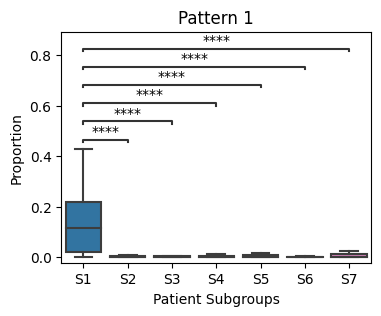

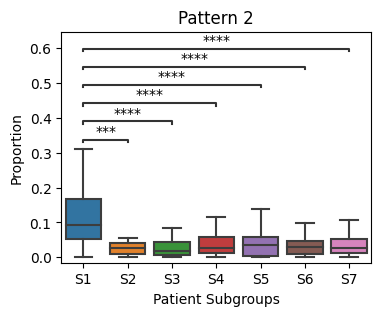

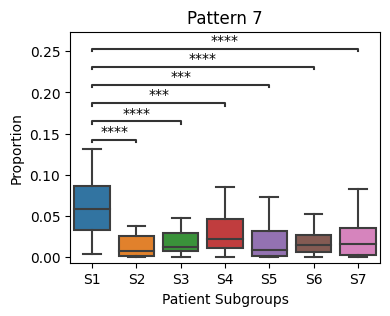

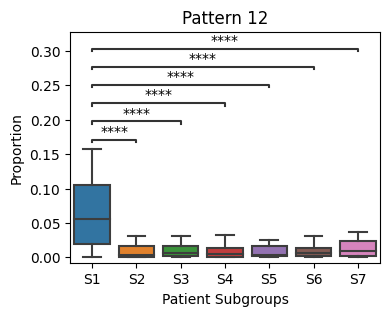

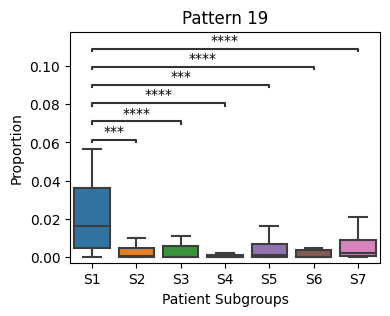

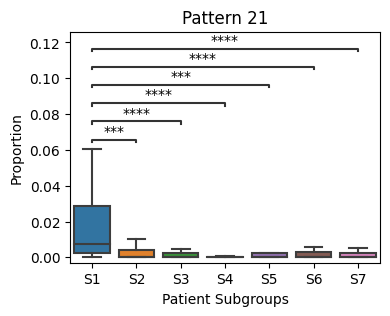

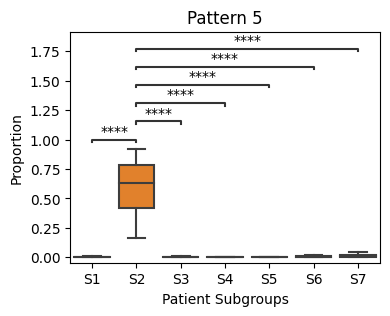

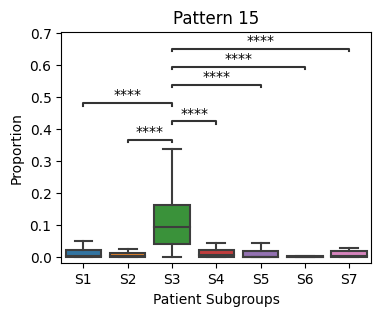

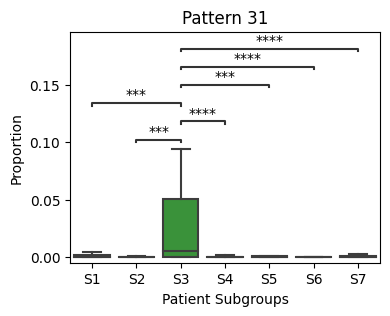

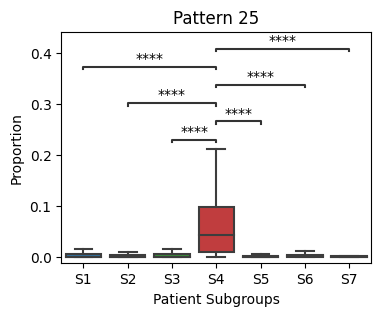

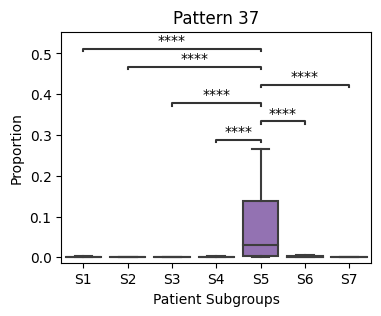

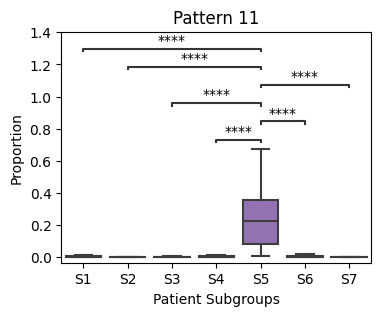

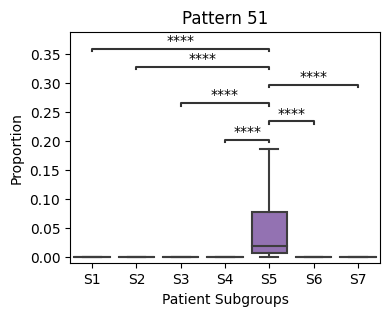

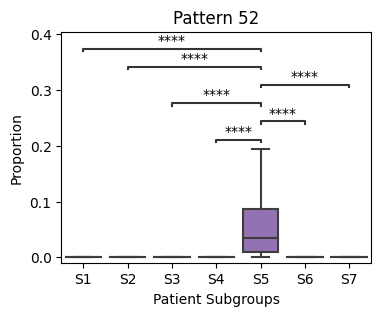

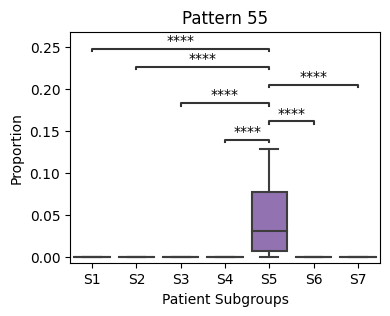

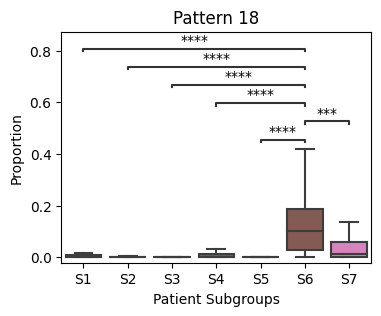

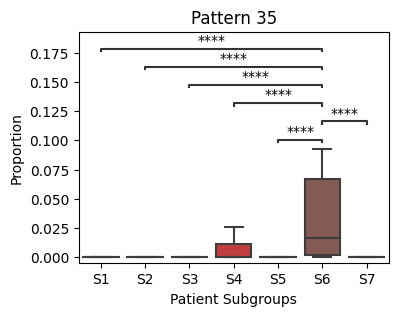

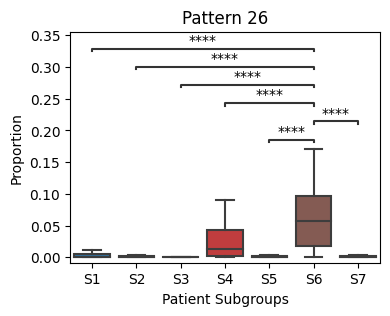

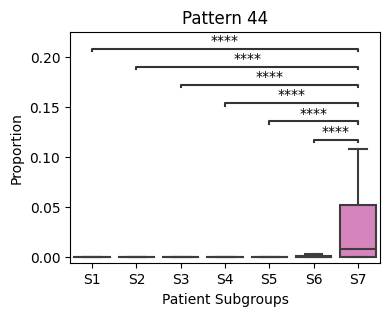

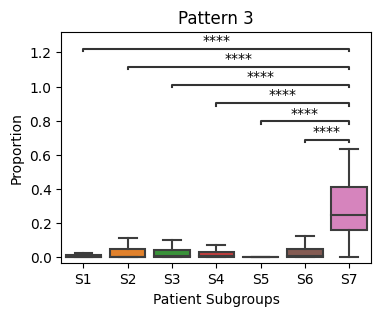

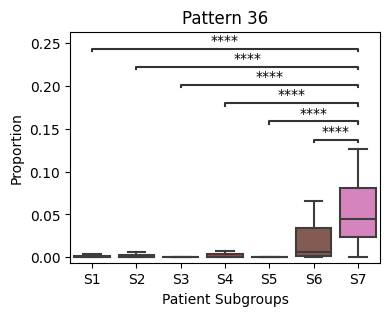

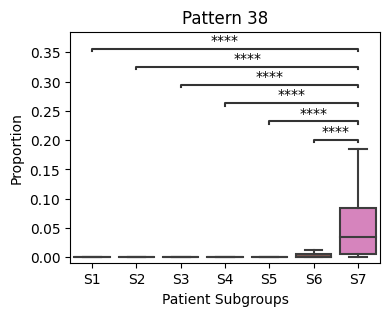

In [202]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    print("Subgroup {}".format(subgroup_id))
    for pattern_id in Candidates:
        histogram = Histograms_[:, pattern_id] 
        DF_presentation = pd.DataFrame(
                {
                    "Proportion": histogram,
                    "Subgroup": ['S'+str(int(i)) for i in Subgroup_ids_],
                }
            )
        DF_presentation = DF_presentation.loc[DF_presentation["Subgroup"] != 0]
        f, ax = plt.subplots(figsize=(4, 3))
        sns.boxplot(
            x="Subgroup",
            y="Proportion",
            data=DF_presentation,
            showfliers=False,
            order=['S'+str(i) for i in range(1, len(HR)+1)],
        )
        from statannotations.Annotator import Annotator
        annot = Annotator(
            ax,
            [("S"+str(subgroup_id), "S"+str(i)) for i in range(1, len(HR)+1) if i != subgroup_id],
            data=DF_presentation,
            x="Subgroup",
            y="Proportion",
            order=['S'+str(i) for i in range(1, len(HR)+1)],
        )
        annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
        annot.apply_test()
        ax, test_results = annot.annotate()
        ax.set_title("Pattern {}".format(pattern_id+1))
        ax.set(ylabel = 'Proportion', xlabel = 'Patient Subgroups')


#### Signature map

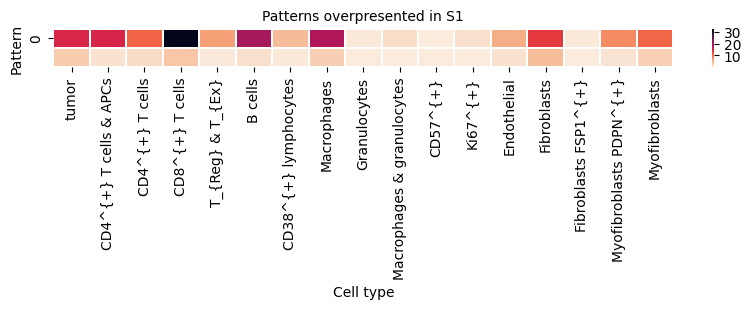

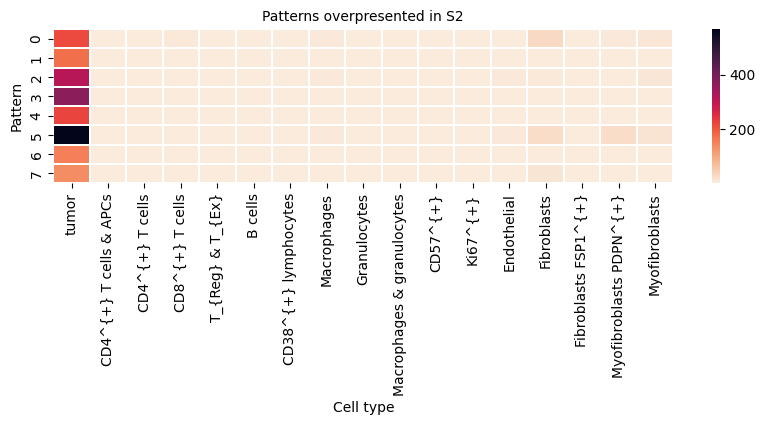

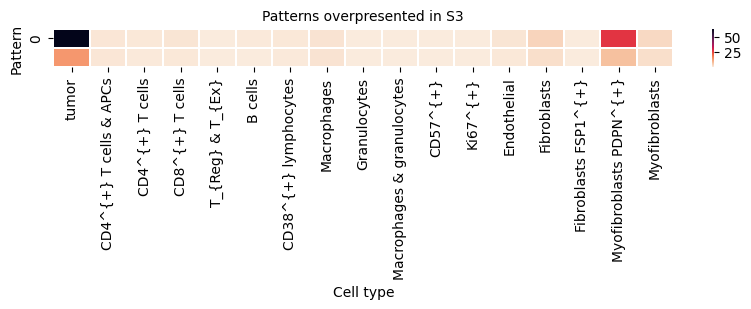

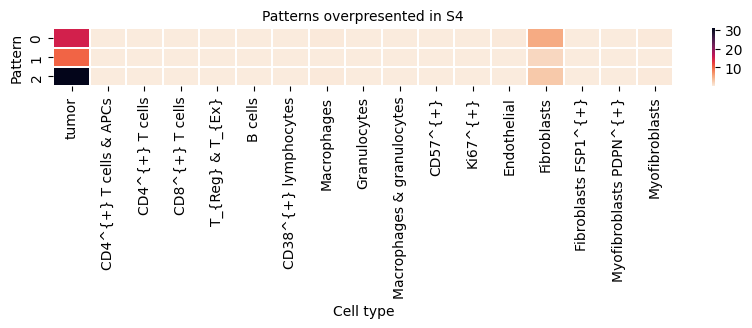

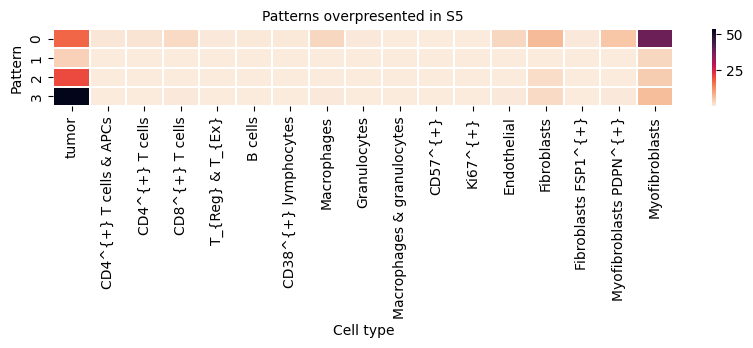

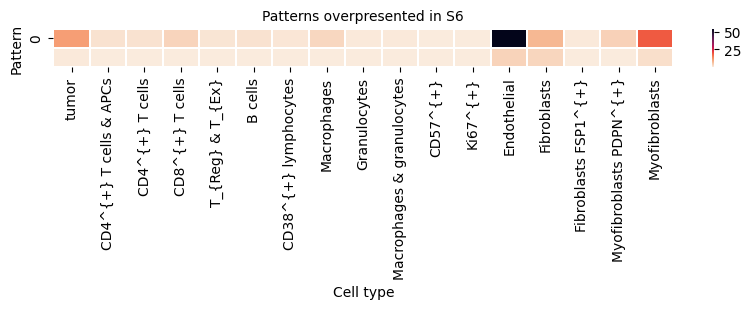

In [265]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_node_id
from utils import reverse_dict

# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(

        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i
    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
Cell_type_name_list = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(Centroids.shape[1])]

for subgroup_id, Candidates in Overpresented_patterns.items():
    # if len(Candidates) <=5:
    #     continue
    f, ax= plt.subplots(1,1,figsize=(10,0.25*len(Candidates)))
    sns.heatmap(
            Signature[:, np.array(Candidates)].T,
            ax=ax,
            cbar=True,
            cmap="rocket_r",
            linewidth=0.005,
            # edgecolor="black",
            # vmax=np.percentile(Signature, 99),
            # vmin=np.percentile(Signature, 1),
        )
    ax.set_xticklabels(Cell_type_name_list, rotation=90, fontsize=10)
    # ax.set_yticklabels([i+1 for i in np.array(Candidates)], fontsize=10)
    # ax.set_ylabel("TME pattern index", fontsize=10)
    ax.set(xlabel = 'Cell type', ylabel = 'Pattern')
    ax.set_title(f"Patterns overpresented in S{subgroup_id}", fontsize=10)
    plt.show()



#### Representative examples

/tmp/ipykernel_4029577/1306095255.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(figsize=(5,5))


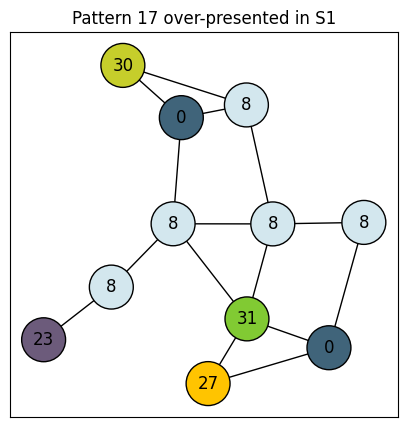

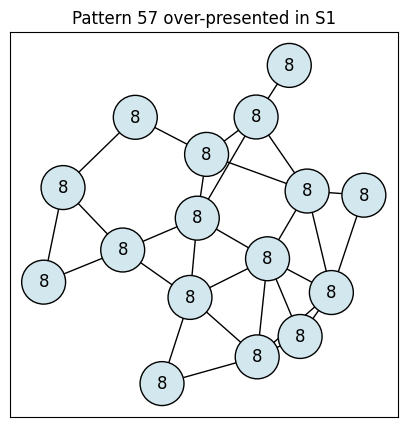

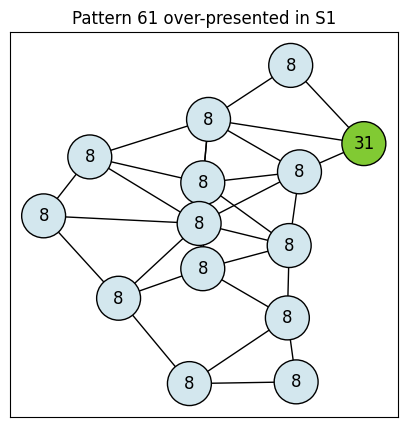

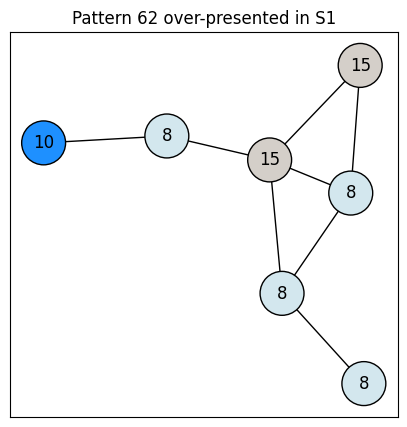

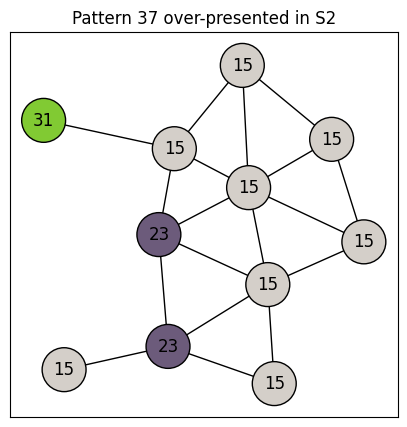

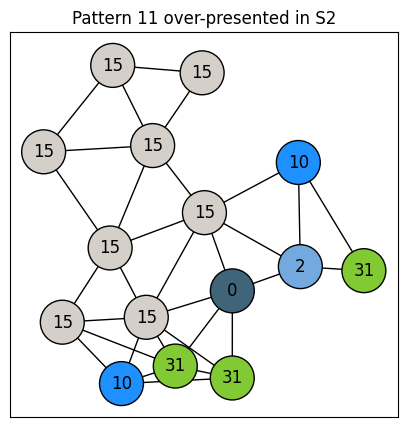

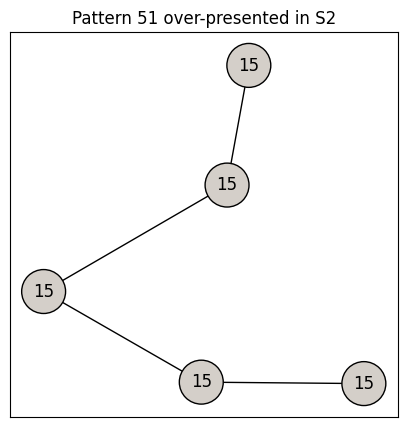

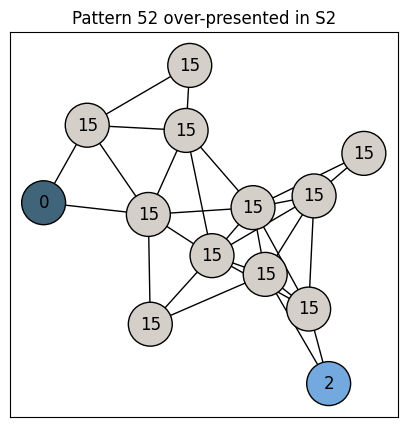

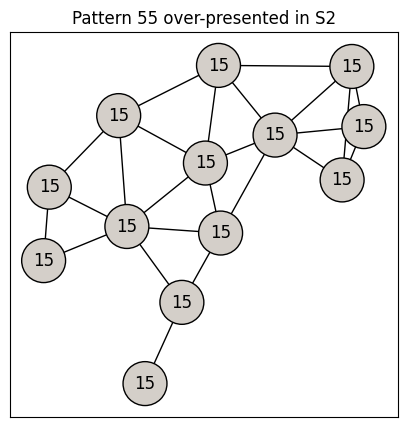

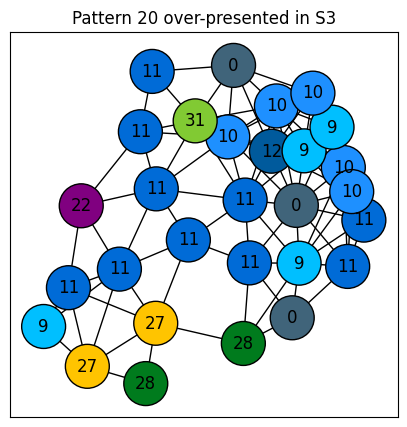

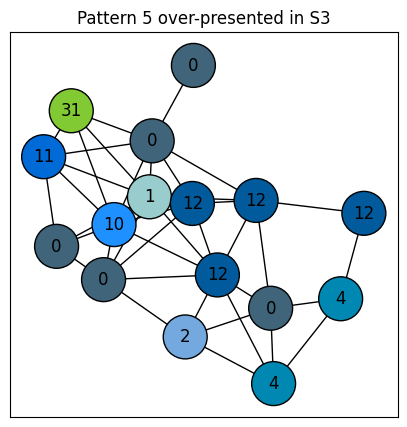

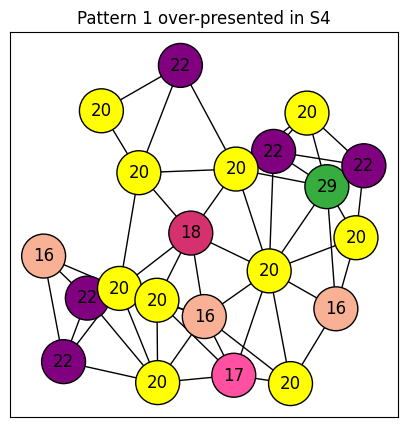

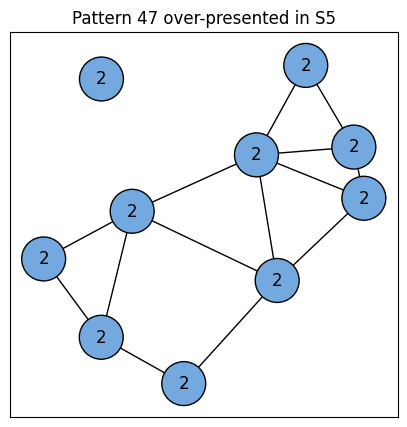

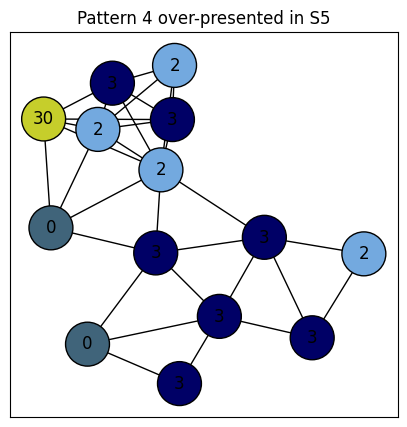

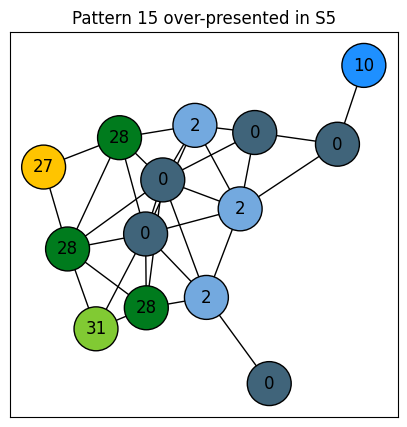

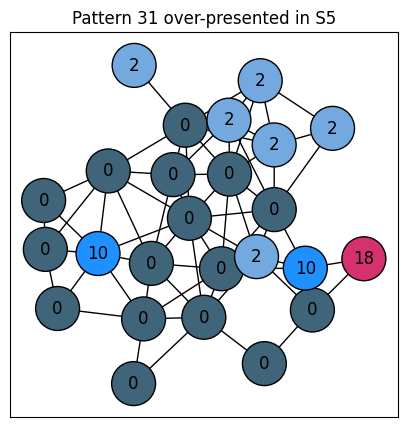

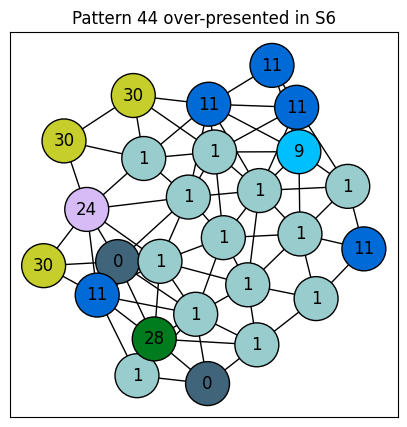

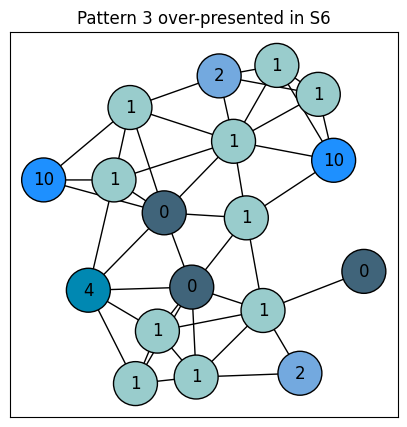

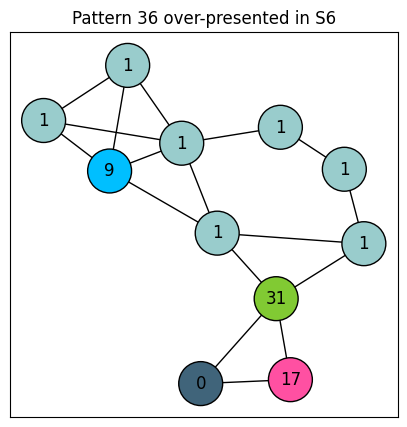

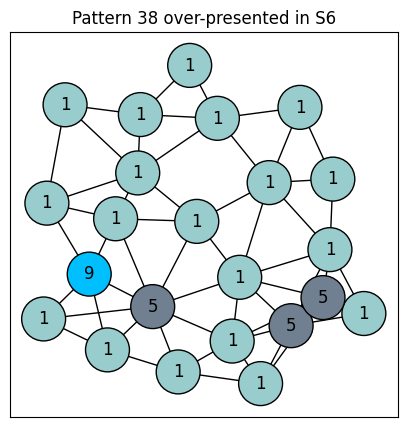

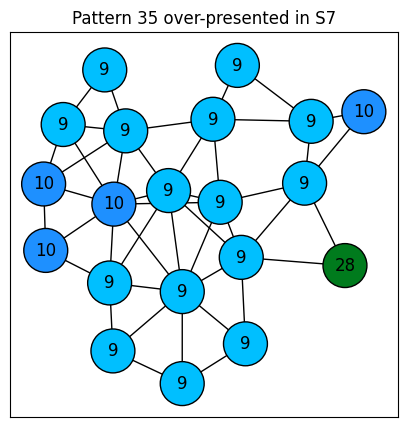

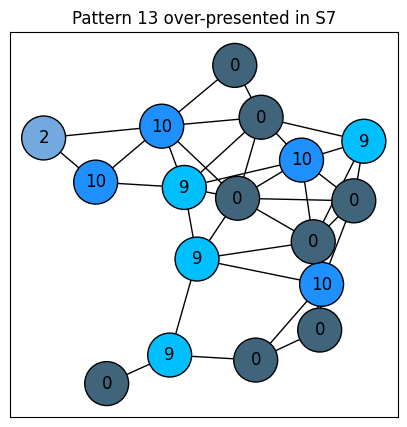

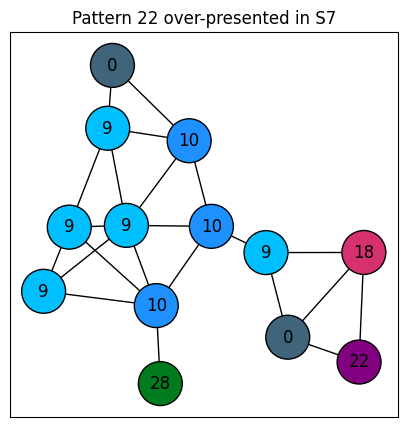

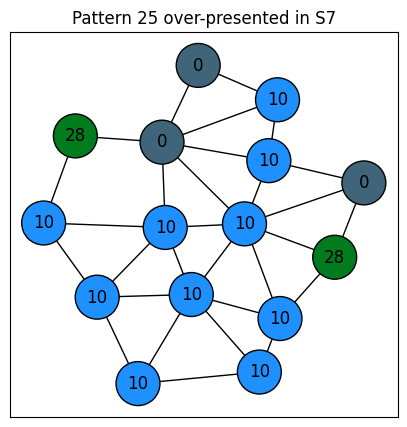

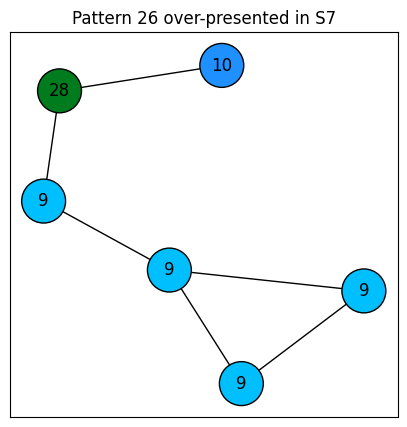

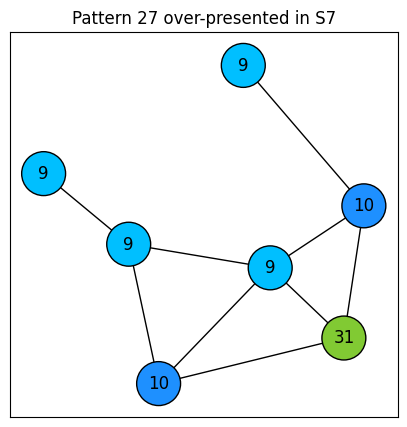

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


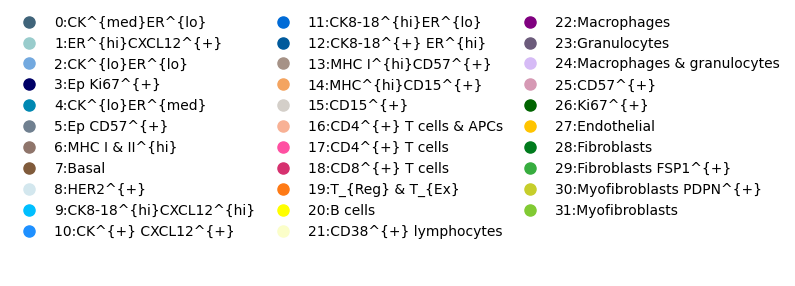

In [94]:
from definitions import get_node_id, get_node_color
from utils import reverse_dict
from overpresented_patterns import find_representative_examples, decide_subtree_boundary, construct_cellular_graph
def get_pos(G):
    x = nx.get_node_attributes(G, "X")
    y = nx.get_node_attributes(G, "Y")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos
def normalize_pos(pos):
    x = np.array([pos[key][0] for key in pos.keys()])
    y = np.array([pos[key][1] for key in pos.keys()])
    x = x - np.mean(x)
    y = y - np.mean(y)
    pos_normalized = {}
    for i, key in enumerate(pos.keys()):
        pos_normalized[key] = (x[i], y[i])
    return pos_normalized

for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        Examples = find_representative_examples(pattern_id, Centroids, FILE_NAMES, X, Cluster_identities, Indices, num_examples = 1)
        for patient_id, image_id, subtree_root_idx in Examples:
            cells_ = pd.read_csv(
                    os.path.join(
                        PROJECT_ROOT,
                        "Input",
                        "Single-cell",
                        "Danenberg",
                        "patient_{}_image_{}.csv".format(patient_id, image_id),
                    )
                )
            Adj = np.load(
                    os.path.join(
                        PROJECT_ROOT,
                        "Output",
                        "a_Cellular_graph_random_split",
                        "Danenberg",
                        "Subset_1",
                        "patient_{}_image_{}".format(patient_id, image_id),
                        "Adj.npy",
                    )
                )
            cell_type_ids = np.load(
                    os.path.join(
                        PROJECT_ROOT,
                        "Output",
                        "a_Cellular_graph_random_split",
                        "Danenberg",
                        "Subset_1",
                        "patient_{}_image_{}".format(patient_id, image_id),
                        node_label+".npy",
                    )
                )
            subtree_leaf_indices = decide_subtree_boundary(subtree_root_idx, Adj, iteration, boundary_weight_threshold = 0.1)
            cell_types = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in cell_type_ids]
            cell_type_colors = [get_node_color("Danenberg", node_label)[i] for i in cell_types]
            cellular_graph = construct_cellular_graph(Adj, cells_, cell_types, cell_type_ids, cell_type_colors, edges_visible=0.05)
            subtree_graph = nx.subgraph(cellular_graph, subtree_leaf_indices)
            f, ax = plt.subplots(figsize=(5,5))
            nx.draw_networkx(
                    subtree_graph,
                    normalize_pos(get_pos(subtree_graph)),
                    node_size=1000,
                    node_color= [value for key, value in nx.get_node_attributes(subtree_graph, "cell_type_color").items()],
                    labels = nx.get_node_attributes(subtree_graph, "cell_type_id"),
                    font_color = 'black',
                    with_labels = True,
                    edgecolors="black",
                    ax=ax,
                )
            ax.set_title("Pattern {} over-presented in S{}".format(pattern_id+1, subgroup_id))
# Print Legend
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [str(i)+":"+reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(len(get_node_id("Danenberg", node_label)))]
handles = [func("o", get_node_color("Danenberg", node_label)[i.split(':')[1]]) for i in cell_types]
ax.legend(
        handles,
        cell_types,
        loc=3,
        framealpha=0,
        frameon=1,
        ncols=3,
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        mode="expand",
        borderaxespad=0.0,
        fontsize=10,
    )
ax.axis("off")
plt.show()

## Merge patterns into some large categories

In [266]:
# Overpresented_patterns_ = {
#     'Tumor niche (Her2+)': [16, 56, 60, 61],
#     # "Her2+ - CD15+": [61],
#     'Immune niche (CD15+)': [36, 10,50, 51, 54],
#     'Tumor niche (ER_low CK_high CXCL12_high)': [34, 12, 21, 24, 25, 26]#[34,  21, 25, 26, 12, 24],
#     # 'Tumor niche (ER_low CK_high CXCL12_high) (2)': [12],
#     # 'Tumor niche (ER_low CK_high CXCL12_high) (3)': [21],
#     # 'Dense stromal': [53]
# }

Overpresented_patterns_ = {
    'S1': [0],
    # "Her2+ - CD15+": [61],
    # 'Tumor interacted with immune and stromal': [0, 1, 33, 3, 5, 9, 17, 19, 21],
    # 'Tumor niche (ER_low CK_high CXCL12_high)': [34, 12, 21, 24, 25, 26]#[34,  21, 25, 26, 12, 24],
    # 'Tumor niche (ER_low CK_high CXCL12_high) (2)': [12],
    # 'Tumor niche (ER_low CK_high CXCL12_high) (3)': [21],
    # 'Dense stromal': [53]
}

In [251]:
Overpresented_patterns_ = Overpresented_patterns

## Test over-presented patterns

Pattern 1: hr = 1.2686835127122298, p = 0.42624412107400944


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


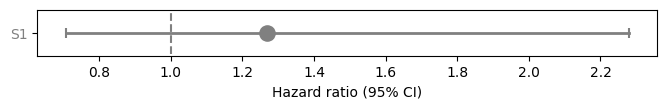

In [267]:
test_metric = 'existence'
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns_.items():
    Num_patterns_to_test += 1

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(8, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
pattern_id = 0
i = 0
for name, Candidates in Overpresented_patterns_.items():
    yticklabels =[name]
    histogram = Histograms_[:, np.array(Candidates)].mean(axis=1)
    if test_metric == 'proportion':
        DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
    elif test_metric == 'existence':
        DF["pattern_"+str(pattern_id+1)] = histogram > 0
    cph = CoxPHFitter()
    cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
    hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
    hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
    hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
    p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
    print("Pattern {}: hr = {}, p = {}".format(pattern_id+1, hr, p))
    if p < 0.05/Num_patterns_to_test:
        color = 'k'
    else:
        color = 'grey'
        
    if Num_patterns_to_test == 1:
        ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax.scatter([hr], [0], color = color, s=120)
        ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax.set_yticks([0])
        ax.set_yticklabels(yticklabels)
        ax.get_yticklabels()[0].set_color(color)
        ax.vlines(1, -1, 1, color="grey", linestyle="--")
    else:
        ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax[i].scatter([hr], [0], color = color, s=120)
        ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax[i].set_yticks([0])
        ax[i].set_yticklabels(yticklabels)
        ax[i].get_yticklabels()[0].set_color(color)
        ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
    i+=1
    pattern_id+=1


if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


0.15


[(0.0, 1.05)]

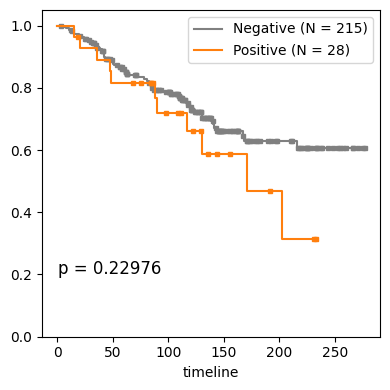

In [273]:
# Tumot Niche(HER2+)
Candidates = Overpresented_patterns_['S1']
histogram = Histograms_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.15
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_[histogram <= threshold], Status_[histogram <= threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_[(histogram > 0.0)&((histogram < threshold))], Status_[(histogram > 0.0)&((histogram < threshold))], 
#                     label='Low (N = {})'.format( np.sum((histogram > 0.0)&((histogram < threshold)))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_[(histogram > threshold)], Status_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2

test = multivariate_logrank_test(Length_, group_label, Status_)
ax_.text(0.5,0.2,"p = {:.5f}".format(test.p_value), fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05] )


In [256]:
Candidates = Overpresented_patterns_['Tumor interacted with immune and stromal']
histogram = Histograms_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_[histogram <= threshold], Status_[histogram <= threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_[(histogram > 0.0)&((histogram < threshold))], Status_[(histogram > 0.0)&((histogram < threshold))], 
#                     label='Low (N = {})'.format( np.sum((histogram > 0.0)&((histogram < threshold)))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_[(histogram > threshold)], Status_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2

test = multivariate_logrank_test(Length_, group_label, Status_)
ax_.text(0.5,0.2,"p = {:.5f}".format(test.p_value), fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05] )

KeyError: 'Tumor interacted with immune and stromal'

0.05


[(0.0, 1.05)]

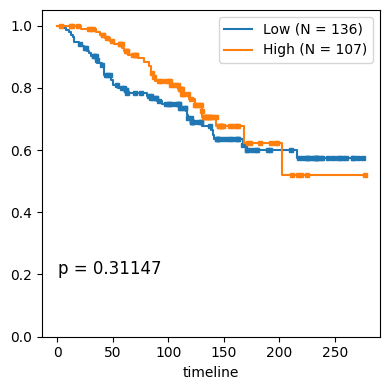

In [106]:
Candidates = Overpresented_patterns_["Tumor niche (ER_low CK_high CXCL12_high)"]
histogram = Histograms_[:, np.array(Candidates)].sum(axis=1)

Indices_clincal_subtype = (Clinical_subtype == 'HR+/HER2-') 
threshold = np.percentile(histogram[Indices_clincal_subtype], 50)
threshold = 0.05
print(threshold)
# threshold = 0.25

fig, ax_ = plt.subplots(figsize=(4, 4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(
    Length_[ ((histogram <= threshold)) & Indices_clincal_subtype],
    Status_[ ((histogram <= threshold)) & Indices_clincal_subtype],
    label="Low (N = {})".format(
        np.sum(((histogram <= threshold)) & Indices_clincal_subtype)
    ),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

kmf.fit(
    Length_[(histogram > threshold) & Indices_clincal_subtype],
    Status_[(histogram > threshold) & Indices_clincal_subtype],
    label="High (N = {})".format(np.sum((histogram > threshold)& Indices_clincal_subtype)),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

group_label = np.zeros_like(histogram)

group_label[(histogram <= threshold) & Indices_clincal_subtype] = 1
group_label[(histogram > threshold) & Indices_clincal_subtype] = 2
group_label = group_label[group_label>0]

test = multivariate_logrank_test(Length_[Indices_clincal_subtype], group_label, Status_[Indices_clincal_subtype])
ax_.text(0.5, 0.2, "p = {:.5f}".format(test.p_value), fontsize=12)
# kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
# kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim=[0, 1.05])

0.05


[(0.0, 1.05)]

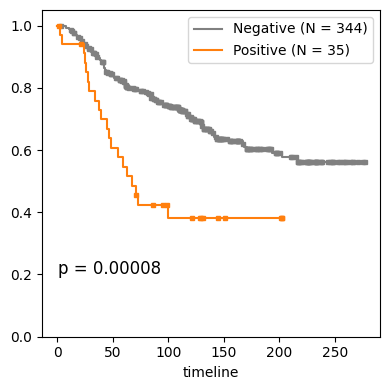

In [49]:
# Tumot Niche(HER2+)
Candidates = Overpresented_patterns_['Tumor niche (Her2+)']
histogram = Histograms_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_[histogram <= threshold], Status_[histogram <= threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_[(histogram > 0.0)&((histogram < threshold))], Status_[(histogram > 0.0)&((histogram < threshold))], 
#                     label='Low (N = {})'.format( np.sum((histogram > 0.0)&((histogram < threshold)))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_[(histogram > threshold)], Status_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2

test = multivariate_logrank_test(Length_, group_label, Status_)
ax_.text(0.5,0.2,"p = {:.5f}".format(test.p_value), fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05] )


0.05


ValueError: operands could not be broadcast together with shapes (379,) (266,) 

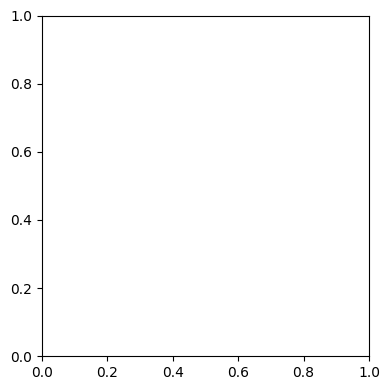

In [50]:
Candidates = Overpresented_patterns_["Tumor niche (Her2+)"]
histogram = Histograms_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
Indices_clincal_subtype = (Clinical_subtype == 'HR-/HER2+') + (Clinical_subtype == 'HR+/HER2+')
fig, ax_ = plt.subplots(figsize=(4, 4), tight_layout=True)
kmf = KaplanMeierFitter()

kmf.fit(
    Length_[ ((histogram < threshold)) & Indices_clincal_subtype],
    Status_[ ((histogram < threshold)) & Indices_clincal_subtype],
    label="Low (N = {})".format(
        np.sum(((histogram < threshold)) & Indices_clincal_subtype)
    ),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

kmf.fit(
    Length_[(histogram > threshold) & Indices_clincal_subtype],
    Status_[(histogram > threshold) & Indices_clincal_subtype],
    label="High (N = {})".format(np.sum((histogram > threshold)& Indices_clincal_subtype)),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

group_label = np.zeros_like(histogram)

group_label[(histogram <= threshold) & Indices_clincal_subtype] = 1
group_label[(histogram > threshold) & Indices_clincal_subtype] = 2
group_label = group_label[group_label>0]

test = multivariate_logrank_test(Length_[Indices_clincal_subtype], group_label, Status_[Indices_clincal_subtype])
ax_.text(0.5, 0.2, "p = {:.5f}".format(test.p_value), fontsize=12)
# kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
# kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim=[0, 1.05], title="Tumor niche (Her2+)")

# Validation

## Subset 2

In [257]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]
Clinical_subtype_cohort2 = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_cohort2]) 
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

116 patients are included


21 72 23
S1 1.2718811587756373 0.11678072475860223


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


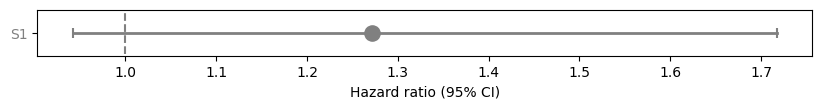

In [258]:
test_metric = 'proportion'
DF = pd.DataFrame({
    'length': Length_cohort2_,
    'status': Status_cohort2_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns_.items():
    Num_patterns_to_test += 1

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(10, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for name, Candidates in Overpresented_patterns_.items():
    yticklabels =[name]
    pattern_id = i
    histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)
    print(np.sum(histogram == 0), np.sum((histogram > 0)&(histogram < 0.1)), np.sum(histogram >=0.1))


    # _, ax__ = plt.subplots(figsize=(5,3), tight_layout=True)
    # ax__.plot(np.sort(histogram), '*')

    if test_metric == 'proportion':
        DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
    elif test_metric == 'existence':
        DF["pattern_"+str(pattern_id+1)] = histogram > 0.001
    cph = CoxPHFitter()
    cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
    hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
    hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
    hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
    p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
    print(name, hr, p)

    if p < 0.05/Num_patterns_to_test:
        color = 'k'
    else:
        color = 'grey'
        
    if Num_patterns_to_test == 1:
        ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax.scatter([hr], [0], color = color, s=120)
        ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax.set_yticks([0])
        ax.set_yticklabels(yticklabels)
        ax.get_yticklabels()[0].set_color(color)
        ax.vlines(1, -1, 1, color="grey", linestyle="--")
    else:
        ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax[i].scatter([hr], [0], color = color, s=120)
        ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax[i].set_yticks([0])
        ax[i].set_yticklabels(yticklabels)
        ax[i].get_yticklabels()[0].set_color(color)
        ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
    i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


0.05


[(0.0, 1.05)]

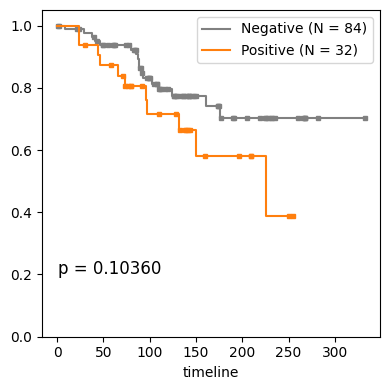

In [259]:
# Tumot Niche(HER2+)
Candidates = Overpresented_patterns_['S1']
histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_cohort2_[histogram <= threshold], Status_cohort2_[histogram <= threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_cohort2_[(histogram > 0.0)&((histogram < threshold))], Status_cohort2_[(histogram > 0.0)&((histogram < threshold))], 
#                     label='Low (N = {})'.format( np.sum((histogram > 0.0)&((histogram < threshold)))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_cohort2_[(histogram > threshold)], Status_cohort2_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2

test = multivariate_logrank_test(Length_cohort2_, group_label, Status_cohort2_)
ax_.text(0.5,0.2,"p = {:.5f}".format(test.p_value), fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05])


0.05


[(0.0, 1.05), Text(0.5, 1.0, 'Tumor niche (Her2+)')]

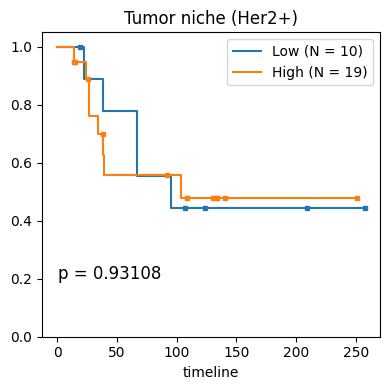

In [54]:
Candidates = Overpresented_patterns_["Tumor niche (Her2+)"]
histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_cohort2_])
Indices_clincal_subtype = (Clinical_subtype == 'HR-/HER2+') + (Clinical_subtype == 'HR+/HER2+')
fig, ax_ = plt.subplots(figsize=(4, 4), tight_layout=True)
kmf = KaplanMeierFitter()

kmf.fit(
    Length_cohort2_[ ((histogram < threshold)) & Indices_clincal_subtype],
    Status_cohort2_[ ((histogram < threshold)) & Indices_clincal_subtype],
    label="Low (N = {})".format(
        np.sum(((histogram < threshold)) & Indices_clincal_subtype)
    ),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

kmf.fit(
    Length_cohort2_[(histogram > threshold) & Indices_clincal_subtype],
    Status_cohort2_[(histogram > threshold) & Indices_clincal_subtype],
    label="High (N = {})".format(np.sum((histogram > threshold)& Indices_clincal_subtype)),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

group_label = np.zeros_like(histogram)

group_label[(histogram <= threshold) & Indices_clincal_subtype] = 1
group_label[(histogram > threshold) & Indices_clincal_subtype] = 2
group_label = group_label[group_label>0]

test = multivariate_logrank_test(Length_cohort2_[Indices_clincal_subtype], group_label, Status_cohort2_[Indices_clincal_subtype])
ax_.text(0.5, 0.2, "p = {:.5f}".format(test.p_value), fontsize=12)
# kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
# kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim=[0, 1.05], title="Tumor niche (Her2+)")

0.05


[(0.0, 1.05)]

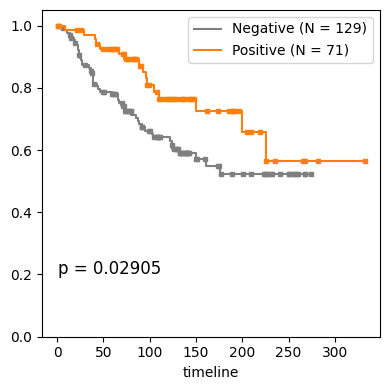

In [55]:
# Tumot Niche(HER2+)
Candidates = Overpresented_patterns_['Tumor niche (ER_low CK_high CXCL12_high)']
histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_cohort2_[histogram <= threshold], Status_cohort2_[histogram <= threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_cohort2_[(histogram > 0.0)&((histogram < threshold))], Status_cohort2_[(histogram > 0.0)&((histogram < threshold))], 
#                     label='Low (N = {})'.format( np.sum((histogram > 0.0)&((histogram < threshold)))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_cohort2_[(histogram > threshold)], Status_cohort2_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2

test = multivariate_logrank_test(Length_cohort2_, group_label, Status_cohort2_)
ax_.text(0.5,0.2,"p = {:.5f}".format(test.p_value), fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05])


0.041806551450575734


[(0.0, 1.05)]

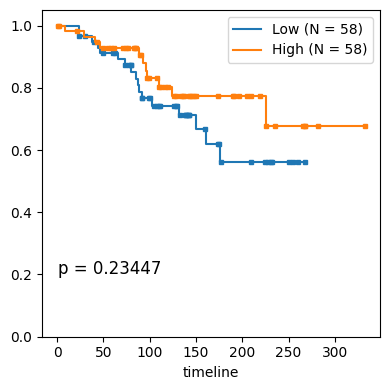

In [76]:
Candidates = Overpresented_patterns_["Tumor niche (ER_low CK_high CXCL12_high)"]
histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)

Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_cohort2_])
Indices_clincal_subtype = (Clinical_subtype == 'HR+/HER2-') 

threshold = np.percentile(histogram[Indices_clincal_subtype], 50)
# threshold = 0.25
print(threshold)

fig, ax_ = plt.subplots(figsize=(4, 4), tight_layout=True)
kmf = KaplanMeierFitter()

kmf.fit(
    Length_cohort2_[ ((histogram < threshold)) & Indices_clincal_subtype],
    Status_cohort2_[ ((histogram < threshold)) & Indices_clincal_subtype],
    label="Low (N = {})".format(
        np.sum(((histogram < threshold)) & Indices_clincal_subtype)
    ),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

kmf.fit(
    Length_cohort2_[(histogram > threshold) & Indices_clincal_subtype],
    Status_cohort2_[(histogram > threshold) & Indices_clincal_subtype],
    label="High (N = {})".format(np.sum((histogram > threshold)& Indices_clincal_subtype)),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

group_label = np.zeros_like(histogram)

group_label[(histogram <= threshold) & Indices_clincal_subtype] = 1
group_label[(histogram > threshold) & Indices_clincal_subtype] = 2
group_label = group_label[group_label>0]

test = multivariate_logrank_test(Length_cohort2_[Indices_clincal_subtype], group_label, Status_cohort2_[Indices_clincal_subtype])
ax_.text(0.5, 0.2, "p = {:.5f}".format(test.p_value), fontsize=12)
# kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
# kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim=[0, 1.05])

## Jackson

In [260]:
from utils import process_Jackson_clinical_data
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]


S1 1.0357217900746236 0.8077980268123581


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


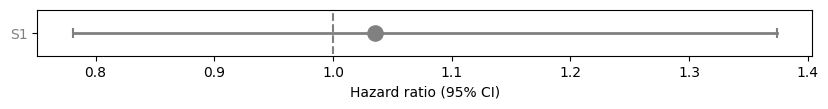

In [261]:
test_metric = 'proportion'
DF = pd.DataFrame({
    'length': Length_jackson_,
    'status': Status_jackson_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns_.items():
    Num_patterns_to_test += 1

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(10, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for name, Candidates in Overpresented_patterns_.items():
    yticklabels =[name]
    pattern_id = i
    histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)
    if test_metric == 'proportion':
        DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
    elif test_metric == 'existence':
        DF["pattern_"+str(pattern_id+1)] = histogram > 0.001
    



    cph = CoxPHFitter()
    cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
    hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
    hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
    hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
    p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
    print(name, hr, p)

    if p < 0.05/Num_patterns_to_test:
        color = 'k'
    else:
        color = 'grey'
        
    if Num_patterns_to_test == 1:
        ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax.scatter([hr], [0], color = color, s=120)
        ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax.set_yticks([0])
        ax.set_yticklabels(yticklabels)
        ax.get_yticklabels()[0].set_color(color)
        ax.vlines(1, -1, 1, color="grey", linestyle="--")
    else:
        ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax[i].scatter([hr], [0], color = color, s=120)
        ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax[i].set_yticks([0])
        ax[i].set_yticklabels(yticklabels)
        ax[i].get_yticklabels()[0].set_color(color)
        ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
    i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


0.05


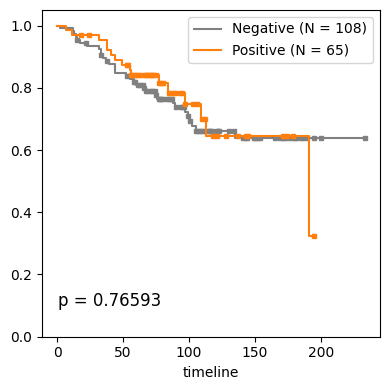

In [262]:
# Tumot Niche(HER2+)
Candidates = Overpresented_patterns_['S1']
histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_jackson_[histogram <= threshold], Status_jackson_[histogram <=threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_jackson_[(histogram > 0.1)&((histogram < 0.2))], Status_jackson_[(histogram > 0.1)&((histogram < 0.2))], label='Positive (N = {})'.format( np.sum((histogram > 0.2))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_jackson_[(histogram > 0.0) & (histogram<=threshold)], Status_jackson_[(histogram > 0.0)& (histogram<=threshold)], label='Low (N = {})'.format( np.sum((histogram > 0.0)& (histogram<=threshold))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_jackson_[(histogram > threshold)], Status_jackson_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2
test = multivariate_logrank_test(Length_jackson_, group_label, Status_jackson_)
ax_.text(0.5, 0.1, "p = {:.5f}".format(test.p_value),fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05])
ax_.legend()



In [263]:
Candidates = Overpresented_patterns_["Tumor niche (Her2+)"]
histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.1
print(threshold)
Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_jackson_])
Indices_clincal_subtype = (Clinical_subtype == 'HR-/HER2+') + (Clinical_subtype == 'HR+/HER2+')
fig, ax_ = plt.subplots(figsize=(4, 4), tight_layout=True)
kmf = KaplanMeierFitter()

kmf.fit(
    Length_jackson_[ ((histogram < threshold)) & Indices_clincal_subtype],
    Status_jackson_[ ((histogram < threshold)) & Indices_clincal_subtype],
    label="Low (N = {})".format(
        np.sum(((histogram < threshold)) & Indices_clincal_subtype)
    ),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

kmf.fit(
    Length_jackson_[(histogram > threshold) & Indices_clincal_subtype],
    Status_jackson_[(histogram > threshold) & Indices_clincal_subtype],
    label="High (N = {})".format(np.sum((histogram > threshold)& Indices_clincal_subtype)),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

group_label = np.zeros_like(histogram)

group_label[(histogram <= threshold) & Indices_clincal_subtype] = 1
group_label[(histogram > threshold) & Indices_clincal_subtype] = 2
group_label = group_label[group_label>0]

test = multivariate_logrank_test(Length_jackson_[Indices_clincal_subtype], group_label, Status_jackson_[Indices_clincal_subtype])
ax_.text(0.5, 0.2, "p = {:.5f}".format(test.p_value), fontsize=12)
# kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
# kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim=[0, 1.05], title="Tumor niche (Her2+)")

KeyError: 'Tumor niche (Her2+)'

In [264]:
# Tumot Niche(HER2+)
Candidates = Overpresented_patterns_['Tumor niche (ER_low CK_high CXCL12_high)']
histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)
threshold = np.percentile(histogram, 75)
threshold = 0.05
print(threshold)
fig, ax_ = plt.subplots(figsize=(4,4), tight_layout=True)
kmf = KaplanMeierFitter()
kmf.fit(Length_jackson_[histogram <= threshold], Status_jackson_[histogram <=threshold], label='Negative (N = {})'.format(np.sum(histogram <= threshold)))
kmf.plot_survival_function(ax=ax_, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_jackson_[(histogram > 0.1)&((histogram < 0.2))], Status_jackson_[(histogram > 0.1)&((histogram < 0.2))], label='Positive (N = {})'.format( np.sum((histogram > 0.2))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# kmf.fit(Length_jackson_[(histogram > 0.0) & (histogram<=threshold)], Status_jackson_[(histogram > 0.0)& (histogram<=threshold)], label='Low (N = {})'.format( np.sum((histogram > 0.0)& (histogram<=threshold))))
# kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

kmf.fit(Length_jackson_[(histogram > threshold)], Status_jackson_[(histogram > threshold)], label='Positive (N = {})'.format( np.sum((histogram > threshold))))
kmf.plot_survival_function(ax=ax_, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

group_label= np.zeros_like(histogram)
group_label[histogram <= threshold] = 0
# group_label[(histogram > 0.0) & (histogram <= threshold)] = 1
group_label[histogram > threshold] = 2
test = multivariate_logrank_test(Length_jackson_, group_label, Status_jackson_)
ax_.text(0.5, 0.1, "p = {:.5f}".format(test.p_value),fontsize = 12)
    # kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
    # kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim = [0,1.05])
ax_.legend()


KeyError: 'Tumor niche (ER_low CK_high CXCL12_high)'

0.0005901445854234287


[(0.0, 1.05)]

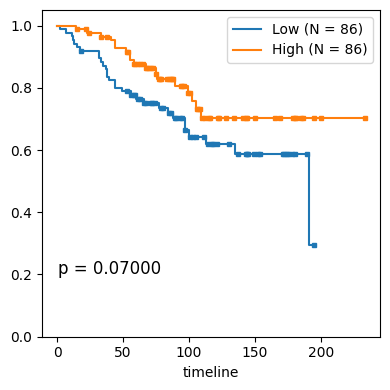

In [83]:
Candidates = Overpresented_patterns_["Tumor niche (ER_low CK_high CXCL12_high)"]
histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)

print(threshold)
Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i, 'Clinical Subtype'].values[0] for i in Patient_IDs_jackson_])
Indices_clincal_subtype = (Clinical_subtype == 'HR+/HER2-') 
threshold = np.percentile(histogram[Indices_clincal_subtype], 50)


fig, ax_ = plt.subplots(figsize=(4, 4), tight_layout=True)
kmf = KaplanMeierFitter()

kmf.fit(
    Length_jackson_[ ((histogram < threshold)) & Indices_clincal_subtype],
    Status_jackson_[ ((histogram < threshold)) & Indices_clincal_subtype],
    label="Low (N = {})".format(
        np.sum(((histogram < threshold)) & Indices_clincal_subtype)
    ),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

kmf.fit(
    Length_jackson_[(histogram > threshold) & Indices_clincal_subtype],
    Status_jackson_[(histogram > threshold) & Indices_clincal_subtype],
    label="High (N = {})".format(np.sum((histogram > threshold)& Indices_clincal_subtype)),
)
kmf.plot_survival_function(
    ax=ax_, ci_show=False, show_censors=True, censor_styles={"ms": 3, "marker": "s"}
)

group_label = np.zeros_like(histogram)

group_label[(histogram <= threshold) & Indices_clincal_subtype] = 1
group_label[(histogram > threshold) & Indices_clincal_subtype] = 2
group_label = group_label[group_label>0]

test = multivariate_logrank_test(Length_jackson_[Indices_clincal_subtype], group_label, Status_jackson_[Indices_clincal_subtype])
ax_.text(0.5, 0.2, "p = {:.5f}".format(test.p_value), fontsize=12)
# kmf.fit(Length_cohort2_[(histogram >= 0.5)], Status_cohort2_[(histogram >= 0.5)], label='high (N = {})'.format(np.sum(histogram >= 0.5)))
# kmf.plot_survival_function(ax=ax_, ci_show=False, color='red',show_censors=True,censor_styles={"ms": 3, "marker": "s"})
ax_.set(ylim=[0, 1.05])